### The University of Melbourne, School of Computing and Information Systems
# COMP90086 Computer Vision, 2022 Semester 2

## Assignment 1

**Student Name:**    `PLEASE ENTER YOUR NAME HERE`

**Student ID:**     `PLEASE ENTER YOUR ID HERE`

This iPython notebook is a template which you should use for your Assignment 3 submission. This file should be submitted at the **Assignment 3: Code** link on the LMS, along with any images needed to run your code.

In addition to this file, you should submit a writren report explaining your results at the **Assignment 3: Report** link on the LMS. Please see the assignment specification for details on what must be included in the report for each question.

*Adding proper comments to your code is MANDATORY.*

### 1. Load images and compute correspondences


In [5]:
import numpy as np
import cv2
import random
import math
from matplotlib import pyplot as plt

In [6]:
# Code from workshop 8
def readImage(fileA, fileB):
    # Read in images from a filepath as graycsale.
    imgA = cv2.imread(fileA, cv2.IMREAD_GRAYSCALE)
    imgB = cv2.imread(fileB, cv2.IMREAD_GRAYSCALE)
    return imgA, imgB

# Code from workshop 7 and 8
def findPoints(imgA, imgB):
    # Initiate SIFT detector
    sift = cv2.SIFT_create()

    # Compute SIFT keypoints and descriptors
    kp1, des1 = sift.detectAndCompute(imgA, None)
    kp2, des2 = sift.detectAndCompute(imgB, None)

    # FLANN parameters and initialize
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Matching descriptor using KNN algorithm
    matches = flann.knnMatch(des1, des2, k=2)

    # Apply ratio test
    good = []

    for i,(m,n) in enumerate(matches):
        if m.distance < 0.8 * n.distance:
            good.append(m)

    # Estimate homography between two images
    ptsA = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
    ptsB = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)

    H, status = cv2.findHomography( ptsA, 
                                    ptsB, 
                                    cv2.RANSAC, 
                                    ransacReprojThreshold = 5, 
                                    maxIters = 500)

    matchesMask = status.ravel().tolist()

    # Draw our inliers
    draw_params = dict(matchColor = (0,255,0), # draw in a specific colour
                    singlePointColor = (255,0,0), # draw in a specific colour
                    matchesMask = matchesMask, # draw only inliers
                    flags = 2)

    success_matches = cv2.drawMatches(imgA,kp1,imgB,kp2,good,None,**draw_params)

    prop = float(np.count_nonzero(matchesMask))/len(matchesMask)
    k = np.log(1 - 0.99)/np.log(1 - math.pow(prop, 8))

    print("Number of points: " + str(len(matchesMask)))
    print("Number of inliers: " + str(np.count_nonzero(matchesMask)))
    print("Number of iterations needed: " + str(k))

    # Plotting results
    plt.imshow(success_matches)
    plt.title('All matches')
    plt.axis('off')

    plt.show()

    return ptsA, ptsB

Number of points: 268
Number of inliers: 91
Number of iterations needed: 26058.806668825448


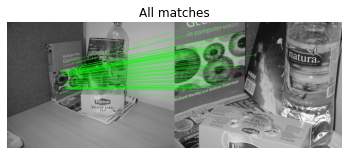

In [7]:
imgA, imgB = readImage("kusvod2/zoomA.png", "kusvod2/zoomB.png")
ptsA, ptsB = findPoints(imgA, imgB)

### 2. Compute the Fundamental Matrix F using the 8 point algorithm

In [10]:
def shift_scale(pts):
    x_centroid = sum([x[0] for x in pts])/len(pts)
    y_centroid = sum([x[1] for x in pts])/len(pts)

    pts_shifted = \
        [[x[0] - x_centroid, x[1] - y_centroid] for x in pts]

    sum_distance = sum([np.sqrt(x[0]**2 + x[1]**2) for x in pts_shifted])
    avg_distance = sum_distance/len(pts_shifted)
    scale_factor = np.sqrt(2) / avg_distance

    T = [[scale_factor, 0,              -scale_factor  * x_centroid],
         [0,            scale_factor,   -scale_factor  * y_centroid],
         [0,            0,              1]]

    pts_shifted_scaled = \
        [[x[0] * scale_factor, x[1] * scale_factor] for x in pts_shifted]

    return pts_shifted_scaled, T

def unshift_scale(F, T1, T2):
    F = T2.transpose() @ F @ T1
    return F

def choose_random_8(ptsA, ptsB):
    idx = random.choices(range(len(ptsA)), k=8)
    ptsA_eight = [ptsA[x] for x in idx]
    ptsB_eight = [ptsB[x] for x in idx]
    return ptsA_eight, ptsB_eight

def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color, 5)
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)
    return img1,img2

def eight_point_loop(ptsA, ptsB, eight=True):
    # Shift and scale pixel coordinates
    
    if (eight):
        ptsA_clean = [x[0] for x in ptsA]
        ptsB_clean = [x[0] for x in ptsB]
        ptsA_eight, ptsB_eight = choose_random_8(ptsA_clean, ptsB_clean)
    else:
        ptsA_clean, ptsB_clean = ptsA, ptsB
        ptsA_eight, ptsB_eight = ptsA_clean, ptsB_clean

    ptsA_ss, TA = shift_scale(ptsA_eight)
    ptsB_ss, TB = shift_scale(ptsB_eight)

    # Construct design matrix
    matrix = []
    for i in range(len(ptsA_ss)):
        p1 = ptsA_ss[i][0]
        p2 = ptsA_ss[i][1]
        q1 = ptsB_ss[i][0]
        q2 = ptsB_ss[i][1]
        row = [p1*q1, p2*q1, q1, p1*q2, p2*q2, q2, p1, p2, 1]
        matrix.append(row)

    # Perform SVD to find null space
    _, _, vh = np.linalg.svd(matrix)

    # Compose draft fundamental matrix
    F = [x[-1] for x in vh]
    F = np.reshape(F, (3, 3))

    # Perform SVD and reassemble
    try:
        u, s, vh = np.linalg.svd(F)
    except:
        return 0, [], [], [], []
    s[-1] = 0
    F = u @ np.diag(s) @ vh

    # Calculate outliers
    lines_A = []
    lines_B = []

    F_uns = unshift_scale(F, np.array(TA), np.array(TB))

    for i in range(len(ptsA)):
        row_B = F_uns @ np.array(np.append(ptsA_clean[i], [1])).reshape(3, 1)
        row_A = F_uns.transpose() @ np.array(np.append(ptsB_clean[i], [1])).reshape(3, 1)
        lines_A.append(row_A.reshape(3, 1).transpose()[0])
        lines_B.append(row_B.reshape(3, 1).transpose()[0])

    inliers = []
    for i in range(len(lines_A)):
        if (abs(np.dot(np.append(ptsA_clean[i], [1]), lines_A[i])) < 1e-3):
            inliers.append((ptsA_clean[i], ptsB_clean[i]))

    return len(inliers), inliers, lines_A, lines_B, F_uns

def calculateF(ptsA, ptsB, name):
    max_n = 0
    max_inliers = []
    for i in range(1000):
        n, inliers, _, _, _ = eight_point_loop(ptsA, ptsB)
        if n > max_n:
            max_n = n
            max_inliers = inliers

    print("File: " + name)
    print("Number of inliers: " + str(max_n))

    max_A = [x[0] for x in max_inliers]
    max_B = [x[1] for x in max_inliers]
    n, inliers, lines_A, lines_B, F = eight_point_loop(max_A, max_B, False)
    return max_A, max_B, lines_A, lines_B

File: zoomA
Number of inliers: 5


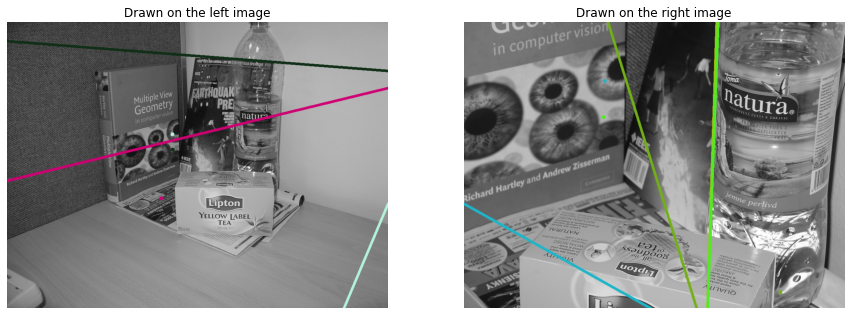

In [11]:
max_A, max_B, lines_A, lines_B = calculateF(ptsA, ptsB, "zoomA")

### 3. Randomly sample 10 correspondences and display images, corresponding points and epipolar lines

In [ ]:
def displayImage(max_A, max_B, lines_A, lines_B, imgA, imgB):
    # TODO: get 10 only
    ptsA_int = [[int(x), int(y)] for [x, y] in max_A]
    ptsB_int = [[int(x), int(y)] for [x, y] in max_B]

    imgL, _ = drawlines(imgA, imgB, lines_A, ptsA_int, ptsB_int)
    imgR, _ = drawlines(imgB, imgA, lines_B, ptsB_int, ptsA_int)

    # Display the results
    plt.subplots(figsize=(15, 15)) 

    plt.subplot(1,2,1)
    plt.imshow(imgL, cmap='gray')  
    plt.title('Drawn on the left image')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(imgR, cmap='gray')  
    plt.title('Drawn on the right image')
    plt.axis('off')

    plt.show()

In [ ]:
displayImage(max_A, max_B, lines_A, lines_B, imgA, imgB)